# TC Profiling Paper Analysis

Manuel Peuster (manuel.peuster@uni-paderborn.de)

In [10]:
# global settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
import numpy as np
import seaborn as sns
import pandas as pd
import itertools
import matplotlib.ticker as ticker
sns.set_style("ticks")
sns.set_context({"figure.figsize": (10, 5)})

## Load data

Do this only once since our data sources can be multiple GB! Uncompressed files are much faster.

In [11]:
%time df = pd.read_pickle("data/2018-04-05-experiment_tc_paper_synthetic_all.combined.pkl")

CPU times: user 8.05 s, sys: 3.61 s, total: 11.7 s
Wall time: 11.7 s


In [12]:
print("Selectors:")
print(list(set(list(df["selector_conf"]))))
print("\n\nPredictors:")
print(list(set(list(df["predictor_conf"]))))


Selectors:
['PGAS_mbp=10', 'WVS_bpm=2-bpmp=False-pspv=10-smmm=0', 'WVS_bpm=0-bpmp=False-pspv=10-smmm=2', 'URS', 'PGAS_mbp=20', 'WVS_bpm=1-bpmp=False-pspv=10-smmm=2', 'WVS_bpm=2-bpmp=False-pspv=10-smmm=1', 'WVS_bpm=2-bpmp=True-pspv=10-smmm=2', 'WVS_bpm=2-bpmp=False-pspv=10-smmm=2']


Predictors:
['RRP_a=0.1-dgr=2-e=0.1-mtd=2', 'PRP_a=0.1-dgr=3-e=0.1-mtd=2', 'SVRPRK_a=0.1-dgr=2-e=0.1-mtd=2', 'DTRP_a=0.1-dgr=2-e=0.1-mtd=5', 'LRP_a=0.1-dgr=2-e=0.1-mtd=2', 'PRP_a=0.1-dgr=2-e=0.1-mtd=2', 'SVRPPK_a=0.1-dgr=2-e=0.1-mtd=2', 'SVRPLK_a=0.1-dgr=2-e=0.1-mtd=2', 'SGDRP_a=0.0001-dgr=2-e=0.1-mtd=2']


## Common Helpers

In [13]:
def _cartesian_product(p_dict):
    """
    Compute Cartesian product on parameter dict:
    In:
        {"number": [1,2,3], "color": ["orange","blue"] }
    Out:
        [ {"number": 1, "color": "orange"},
          {"number": 1, "color": "blue"},
          {"number": 2, "color": "orange"},
          {"number": 2, "color": "blue"},
          {"number": 3, "color": "orange"},
          {"number": 3, "color": "blue"}
        ]
    """
    p_names = sorted(p_dict)
    return [dict(zip(p_names, prod)) for prod in it.product(
        *(p_dict[n] for n in p_names))]

def _generate_filters(df, column_lst):
    """
    config defines arbitrary column names over which we want to iterate
    to create multiple plots, we fetch the possible values of each column
    from the dataset, and compute a float list (cartesian_product) of
    configuration combinations to be plotted
    """
    # extract possible values
    filter_dict = dict()
    for column in column_lst:
        filter_dict[column] = list(set(df[column]))
    # all combinations
    return _cartesian_product(filter_dict)

def _filter_df_by_dict(df, filter_dict):
    """
    do some Pandas magic to dynamically filter df by given dict
    filter_dict = {"column1": "value", "column2": ...}
    """
    return df.loc[
         (df[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]

In [14]:
def error_plot(df, filter_dict,
                  title="selector comparison",
                  x="k_samples", y="error_value",
                  hue="selector_conf", # errors are based on this grouping
                  error_bars=95, # ="sd" or =95 (for ci)
                  y_limit=None,
                  x_label="k samples",
                  y_label="error",
                  fig_width=8,
                  fig_height=6):
    sns.set_context("paper", rc={
                    "lines.linewidth": .5,
                    "lines.markersize": 10})
    # filters (one filter per plot)
    if isinstance(filter_dict, dict):
        filter_dict_list = [filter_dict]
    else:
        filter_dict_list = filter_dict
    # iterate over all filters to gen. diff. plots
    for f in filter_dict_list:
        # select data to be plotted
        dff = _filter_df_by_dict(df, f)
        if len(dff) < 1:
            print("Filter {} returned 0 data entires.".format(f))
            continue  # nothing to plot
        print("Filtered plot data has {} entries".format(len(dff)))
        fig, ax = plt.subplots(
            figsize=(fig_width,
                     fig_height),
                     dpi=300)
        # do plot
        sns.pointplot(ax=ax,
                      data=dff,
                      x=x,
                      y=y,
                      hue=hue,
                      ci=error_bars,  # ci="sd" or ci=95
                      capsize=.3)

        # create legend
        ax.legend(loc='upper center')
        fig.suptitle(title)
        ax.set_title(str(f))
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        if y_limit is not None:
            ax.set_ylim(y_limit)
        #fig.savefig(path, bbox_inches="tight")
        plt.show()

## Preditor comparisson

Compare different preid

Filtered plot data has 302400 entries


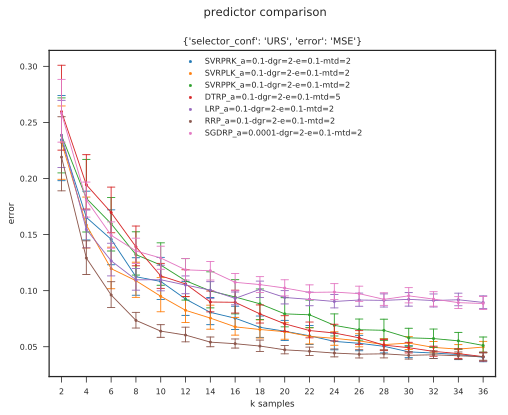

Filtered plot data has 302400 entries


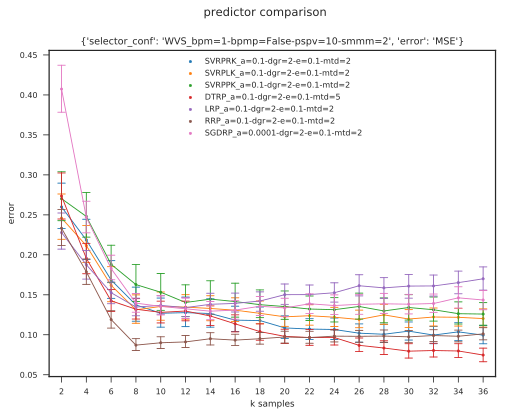

In [15]:
ERRORS = ["MSE"]#, "R"]
SELECTORS = [#'PGAS_mbp=10',
             #'WVS_bpm=2-bpmp=False-pspv=10-smmm=0',
             #'WVS_bpm=0-bpmp=False-pspv=10-smmm=2',
             'URS',
             #'PGAS_mbp=20',
             'WVS_bpm=1-bpmp=False-pspv=10-smmm=2',
             #'WVS_bpm=2-bpmp=False-pspv=10-smmm=1',
             #'WVS_bpm=2-bpmp=True-pspv=10-smmm=2',
             #'WVS_bpm=2-bpmp=False-pspv=10-smmm=2'
            ]


# remove poly predictors
dff = df[df["predictor"] != "PRP"]

# plot combined topologies
for sel in SELECTORS:
    for err in ERRORS:
        error_plot(
            dff,
            {
             "selector_conf": sel,
             "error": err
            },
            hue="predictor_conf",
            title="predictor comparison",
            #y_limit=[-1.0, 1.0] if err == "R" else [0, 1.0],
        )

## Selector comparison

Filtered plot data has 388800 entries


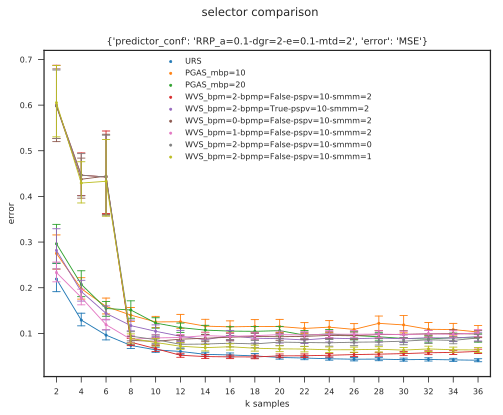

Filtered plot data has 388800 entries


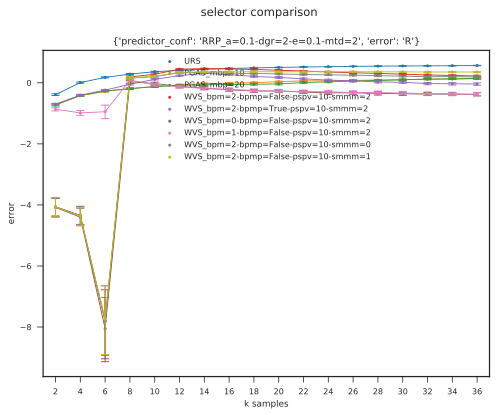

Filtered plot data has 388800 entries


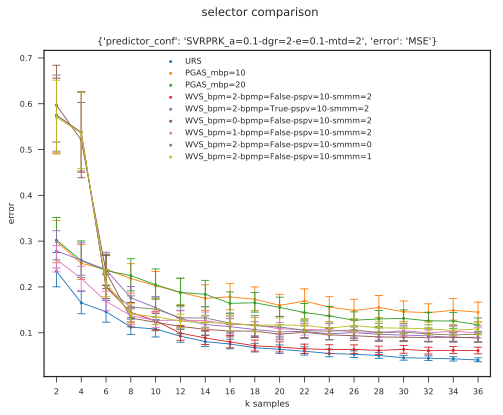

Filtered plot data has 388800 entries


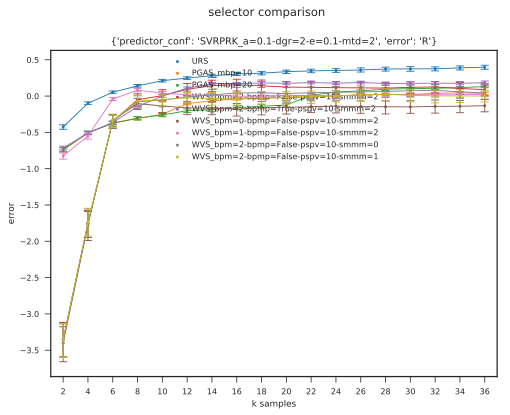

Filtered plot data has 388800 entries


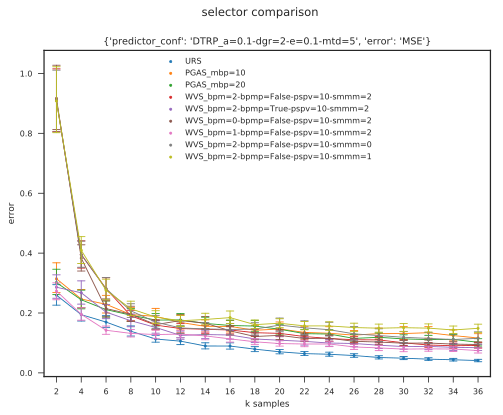

Filtered plot data has 388800 entries


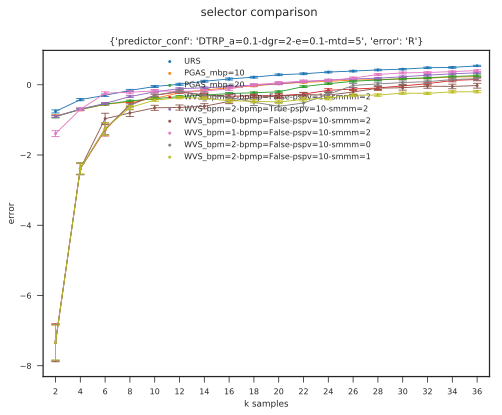

Filtered plot data has 388800 entries


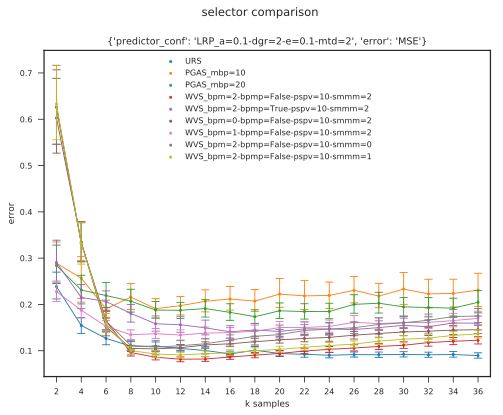

Filtered plot data has 388800 entries


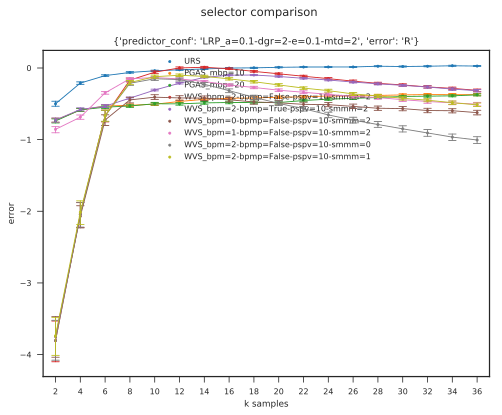

In [16]:
ERRORS = ["MSE", "R"]
PREDICTORS = ['RRP_a=0.1-dgr=2-e=0.1-mtd=2',
             #'PRP_a=0.1-dgr=3-e=0.1-mtd=2',
             'SVRPRK_a=0.1-dgr=2-e=0.1-mtd=2',
             'DTRP_a=0.1-dgr=2-e=0.1-mtd=5',
             'LRP_a=0.1-dgr=2-e=0.1-mtd=2',
             #'PRP_a=0.1-dgr=2-e=0.1-mtd=2',
             #'SVRPPK_a=0.1-dgr=2-e=0.1-mtd=2',
             #'SVRPLK_a=0.1-dgr=2-e=0.1-mtd=2',
             #'SGDRP_a=0.0001-dgr=2-e=0.1-mtd=2'
            ]

for pred in PREDICTORS:
    for err in ERRORS:
        error_plot(
                df, 
                {#"topology": topo,
                 "predictor_conf": pred,  # PRP / SVRP
                 "error": err
                },
                #y_limit=[-1.0, 1.0] if err == "R" else [0, 1.0],
            )

Filtered plot data has 48600 entries


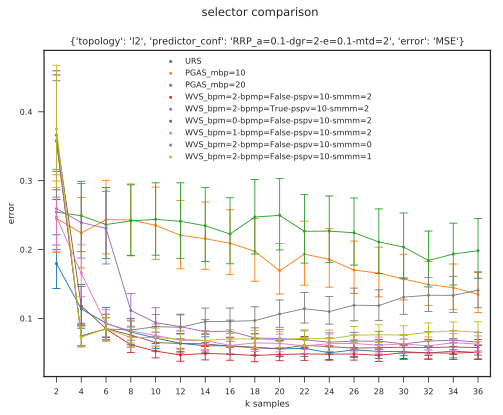

Filtered plot data has 48600 entries


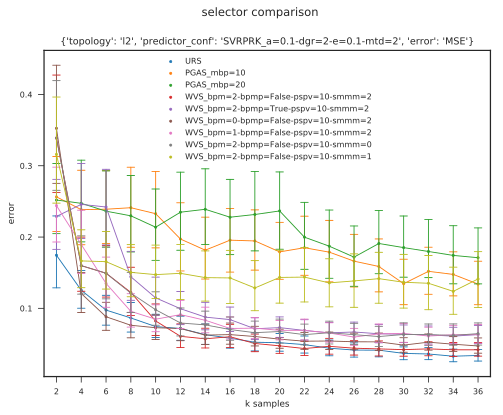

Filtered plot data has 48600 entries


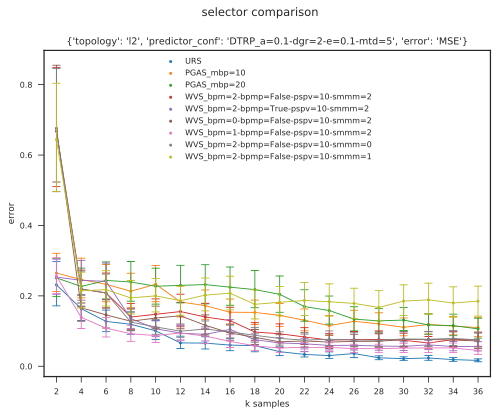

Filtered plot data has 48600 entries


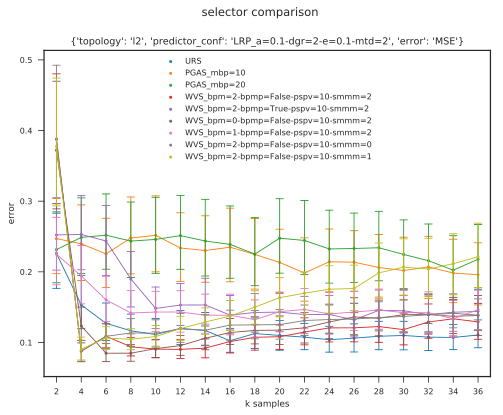

Filtered plot data has 48600 entries


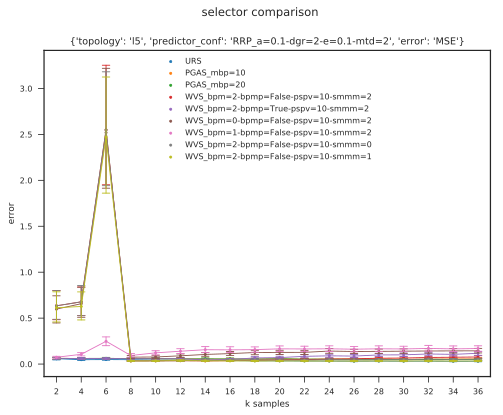

Filtered plot data has 48600 entries


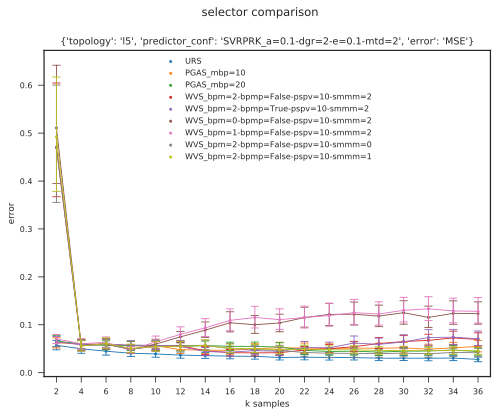

Filtered plot data has 48600 entries


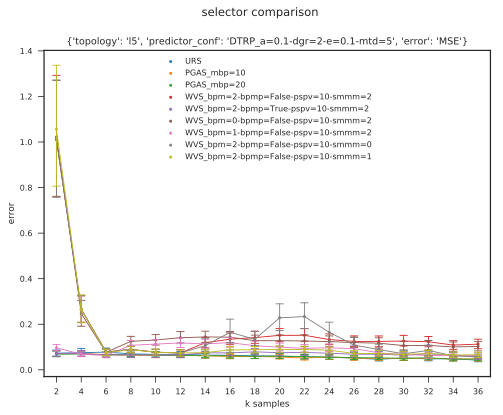

Filtered plot data has 48600 entries


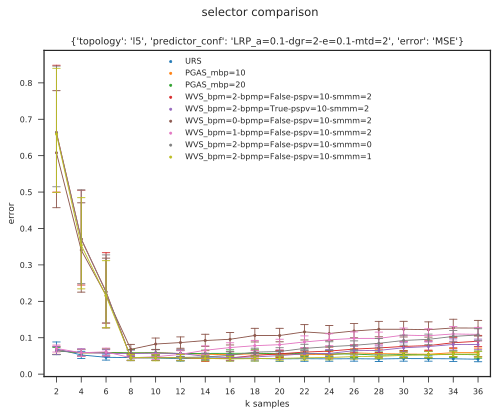

Filtered plot data has 48600 entries


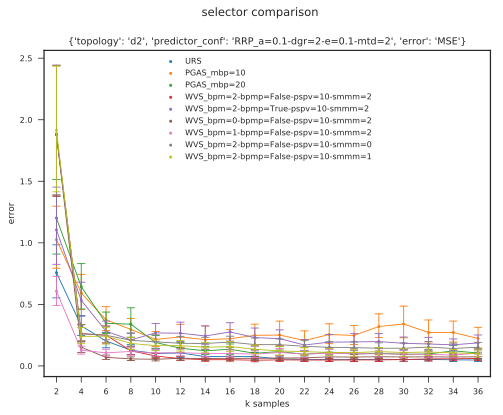

Filtered plot data has 48600 entries


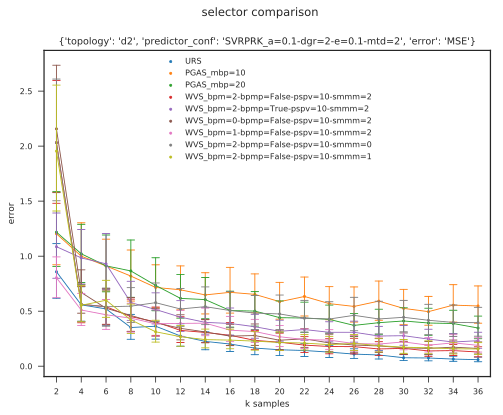

Filtered plot data has 48600 entries


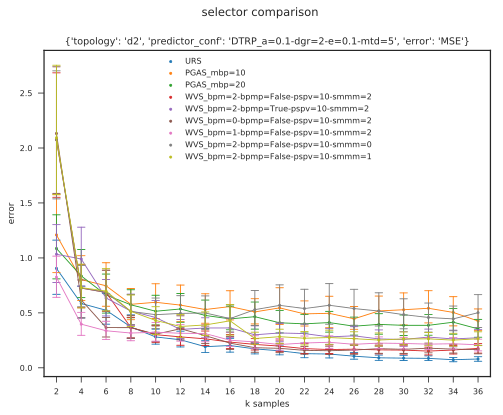

Filtered plot data has 48600 entries


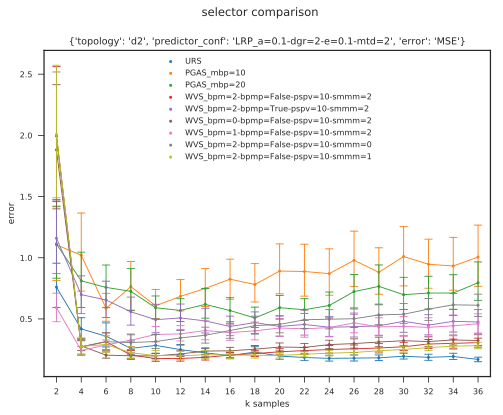

Filtered plot data has 48600 entries


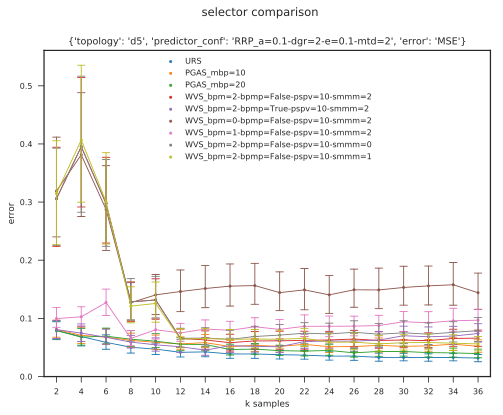

Filtered plot data has 48600 entries


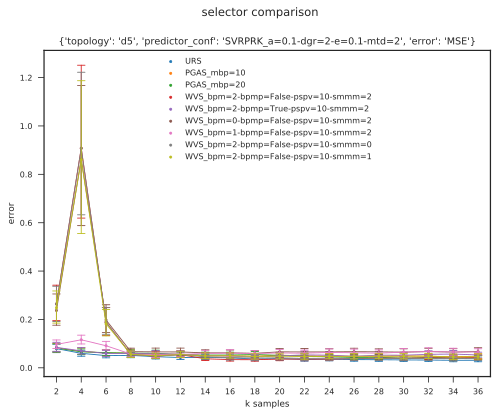

Filtered plot data has 48600 entries


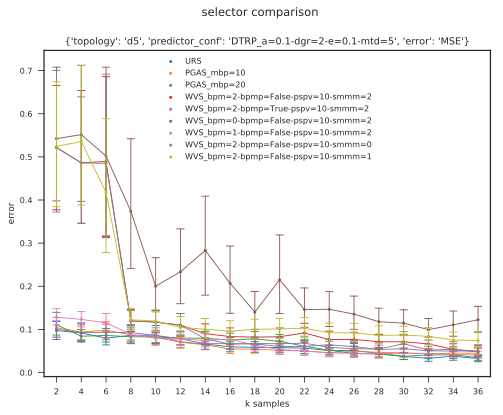

Filtered plot data has 48600 entries


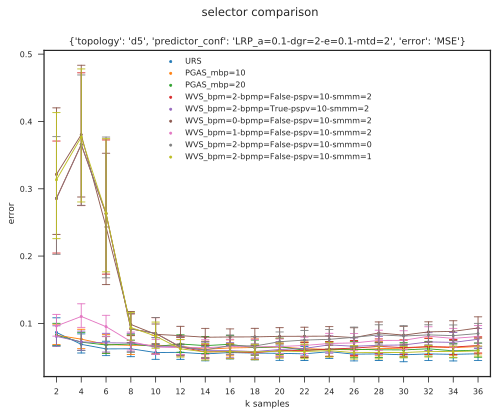

In [17]:
# plot single topologies
TOPOLOGIES = ["l2", "l5", "d2", "d5"]
ERRORS = ["MSE"]
for topo in TOPOLOGIES:
    for pred in PREDICTORS:
        for err in ERRORS:
            error_plot(
                df, 
                {"topology": topo,
                 "predictor_conf": pred,  # PRP / SVRP
                 "error": err
                },
                #y_limit=[-1.0, 1.0] if err == "R" else [0, 1.0],
            )

## Selector runtime study

Filtered plot data has 388800 entries


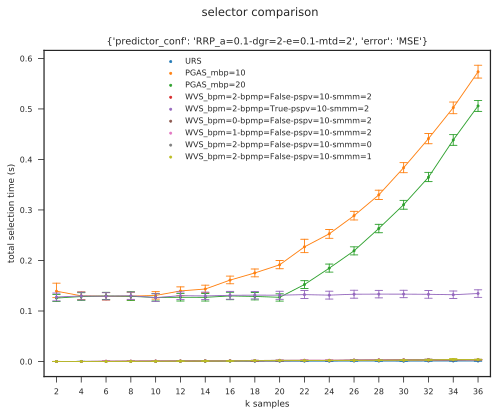

In [18]:
ERRORS = ["MSE"]
PREDICTORS = ['RRP_a=0.1-dgr=2-e=0.1-mtd=2',
             #'PRP_a=0.1-dgr=3-e=0.1-mtd=2',
             #'SVRPRK_a=0.1-dgr=2-e=0.1-mtd=2',
             #'DTRP_a=0.1-dgr=2-e=0.1-mtd=5',
             #'LRP_a=0.1-dgr=2-e=0.1-mtd=2',
             #'PRP_a=0.1-dgr=2-e=0.1-mtd=2',
             #'SVRPPK_a=0.1-dgr=2-e=0.1-mtd=2',
             #'SVRPLK_a=0.1-dgr=2-e=0.1-mtd=2',
             #'SGDRP_a=0.0001-dgr=2-e=0.1-mtd=2'
            ]
TOPOLOGIES = ["all"]

for topo in TOPOLOGIES:
    for pred in PREDICTORS:
        for err in ERRORS:
            error_plot(df,
                       {#"topology": topo,
                        "predictor_conf": pred,
                        "error": err
                       },
                       y="selector_time_next_sum",
                       #y_limit=[0, .9],
                       y_label="total selection time (s)"
                       )